Accuracy: 0.8285198555956679

Precision: 0.8165539480456395
Recall: 0.8285198555956679


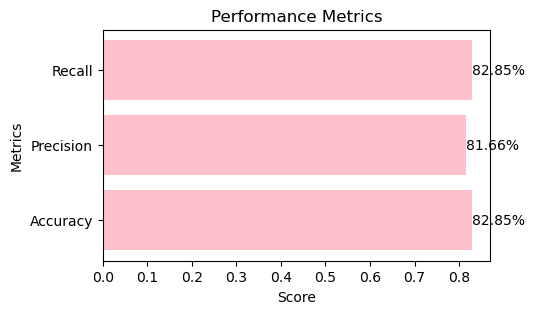


Review Sentiment Percentages:
Positive: 73.47%
Negative: 6.77%
Neutral: 19.77%


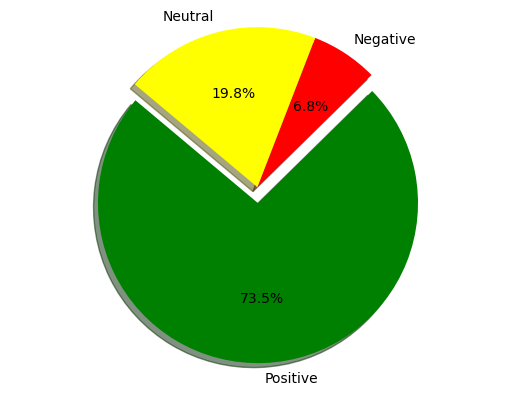



TOP NEGATIVE COMMENTS
Sentiment: negative, Score: -8.00
Review: i've owned this laptop for a year and a half, and felt compelled to take time out of my frantic day to note that i really think this computer is a giant step backward for the macbook air model and for macintosh as a brand compared to my old 2013 macbook air running yosemite.the lack of a mag-safe connection for the charger is really unforgivable, and this computer has wound up on the floor so frequently that i now have placed the dog bed where the laptop is likely to land.  the keys are beginning to stick.  the screen is beautiful, but gives me a terrible headache.  the memory pressure issue with the m1 is also a real problem in safari, which locks up about every three weeks if you have a lot of windows open-- and it take a long time to force quit safely and recover lost work.  the laptop is also too big-- that extra inch or so of width really makes a difference.  the loss of practical functionality in itunes is really d

In [7]:
# Using Logistic Regression to classify By Afrin
import csv
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
# Initialize an empty list to hold all of our comments
comments = []

# A helper function that removes all the non ASCII characters
# from the given string. Returns a string with only ASCII characters.
def strip_non_ascii(string):
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

# LOAD AND CLEAN DATA

# Load in the input file and process each row at a time.
# We assume that the file has three columns:
# 0. The comment text.
# 1. The comment ID.
# 2. The comment publish date
#
# Create a data structure for each comment:
#
# id:       The ID of the comment
# pubdate:  The publication date of the comment
# orig:     The original, unpreprocessed string of characters
# clean:    The preprocessed string of characters

with open('apple_product_review.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Skip the header
    for row in reader:
        comment = dict()
        comment['orig'] = row[0]
        comment['id'] = int(row[1])
        comment['pubdate'] = int(row[2])

        # Ignore retweets
        if re.match(r'^RT.*', comment['orig']):
            continue

        comment['clean'] = comment['orig']

        # Remove all non-ascii characters
        comment['clean'] = strip_non_ascii(comment['clean'])

        # Normalize case
        comment['clean'] = comment['clean'].lower()

        # Remove the hashtag symbol
        comment['clean'] = comment['clean'].replace(r'#', '')

        comments.append(comment)

# Create a data structure to hold the lexicon.
# We will use a Python dictionary. The key of the dictionary will be the word
# and the value will be the word's score.
lexicon = dict()

# Read in the lexicon.
with open('subjectivity_clues_hltemnlp05/lexicon_easy.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon[row[0]] = int(row[1])

# Use lexicon to score comments
for comment in comments:
    score = 0
    for word in comment['clean'].split():
        if word in lexicon:
            score = score + lexicon[word]

    comment['score'] = score
    if score > 0:
        comment['sentiment'] = 'positive'
    elif score < 0:
        comment['sentiment'] = 'negative'
    else:
        comment['sentiment'] = 'neutral'

# Extract features and labels
X = [comment['clean'] for comment in comments]
y = [comment['sentiment'] for comment in comments]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train logistic regression model
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)

metrics = [ 'Accuracy' , 'Precision','Recall']
values = [accuracy_score(y_test, y_pred),precision, recall,]

# horizontal histogram
plt.figure(figsize=(5, 3))
bars = plt.barh(metrics, values, color=['pink', 'pink', 'pink'])
plt.title('Performance Metrics')
plt.xlabel('Score')
plt.ylabel('Metrics')
for bar, value in zip(bars, values):
    plt.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2%}', va='center', ha='left')
    
plt.show()

# Calculate percentages
num_pos = sum(1 for sentiment in y_test if sentiment == 'positive')
num_neg = sum(1 for sentiment in y_test if sentiment == 'negative')
num_neu = sum(1 for sentiment in y_test if sentiment == 'neutral')
total_reviews = len(y_test)

percentage_pos = num_pos / total_reviews * 100
percentage_neg = num_neg / total_reviews * 100
percentage_neu = num_neu / total_reviews * 100

# Print percentages
print("\nReview Sentiment Percentages:")
print(f"Positive: {num_pos / total_reviews * 100:.2f}%")
print(f"Negative: {num_neg / total_reviews * 100:.2f}%")
print(f"Neutral: {num_neu / total_reviews * 100:.2f}%")

# Create a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [percentage_pos, percentage_neg, percentage_neu]
colors = ['green', 'red', 'yellow']
explode = (0.1, 0, 0)  # explode the 1st slice (Positive)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

# Get the probabilities for each class
y_prob = classifier.predict_proba(X_test_tfidf)

# Add probabilities to the test data
test_data_with_prob = list(zip(X_test, y_test, y_prob))
test_data_with_prob = sorted(test_data_with_prob, key=lambda x: max(x[2]), reverse=True)

# Sort comments based on the score
comments_sorted = sorted(comments, key=lambda k: k['score'])

# Print top negative comments
print("\n\nTOP NEGATIVE COMMENTS")
negative_comments = [c for c in comments_sorted if c['sentiment'] == 'negative']
for comment in negative_comments[:10]:
    print(f"Sentiment: {comment['sentiment']}, Score: {comment['score']:.2f}\nReview: {comment['clean']}\n")

# Print top positive comments
print("\n\nTOP POSITIVE COMMENTS")
positive_comments = [c for c in comments_sorted if c['sentiment'] == 'positive']
for comment in positive_comments[-10:]:
    print(f"Sentiment: {comment['sentiment']}, Score: {comment['score']:.2f}\nReview: {comment['clean']}\n")

# Print top neutral comments
print("\n\nTOP NEUTRAL COMMENTS")
neutral_comments = [c for c in comments_sorted if c['sentiment'] == 'neutral']
for comment in neutral_comments[:10]:
    print(f"Sentiment: {comment['sentiment']}, Score: {comment['score']:.2f}\nReview: {comment['clean']}\n")


Accuracy: 0.8294223826714802

Precision: 0.8193867832156815
Recall: 0.8294223826714802


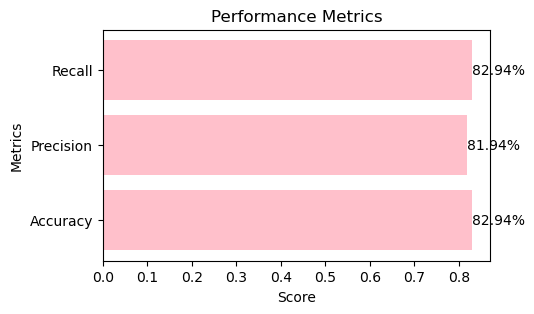


Review Sentiment Percentages:
Positive: 73.47%
Negative: 6.77%
Neutral: 19.77%


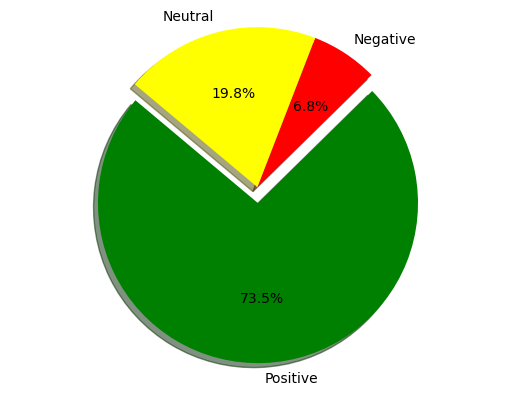



TOP NEGATIVE COMMENTS
Sentiment: negative, Score: -8.00
Review: i've owned this laptop for a year and a half, and felt compelled to take time out of my frantic day to note that i really think this computer is a giant step backward for the macbook air model and for macintosh as a brand compared to my old 2013 macbook air running yosemite.the lack of a mag-safe connection for the charger is really unforgivable, and this computer has wound up on the floor so frequently that i now have placed the dog bed where the laptop is likely to land.  the keys are beginning to stick.  the screen is beautiful, but gives me a terrible headache.  the memory pressure issue with the m1 is also a real problem in safari, which locks up about every three weeks if you have a lot of windows open-- and it take a long time to force quit safely and recover lost work.  the laptop is also too big-- that extra inch or so of width really makes a difference.  the loss of practical functionality in itunes is really d

In [8]:
# Using SVM to Classify by Afrin
import csv
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Initialize an empty list to hold all of our comments
comments = []

# A helper function that removes all the non ASCII characters
# from the given string. Returns a string with only ASCII characters.
def strip_non_ascii(string):
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

# LOAD AND CLEAN DATA

# Load in the input file and process each row at a time.
# We assume that the file has three columns:
# 0. The comment text.
# 1. The comment ID.
# 2. The comment publish date
#
# Create a data structure for each comment:
#
# id:       The ID of the comment
# pubdate:  The publication date of the comment
# orig:     The original, unpreprocessed string of characters
# clean:    The preprocessed string of characters

with open('apple_product_review.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Skip the header
    for row in reader:
        comment = dict()
        comment['orig'] = row[0]
        comment['id'] = int(row[1])
        comment['pubdate'] = int(row[2])

        # Ignore retweets
        if re.match(r'^RT.*', comment['orig']):
            continue

        comment['clean'] = comment['orig']

        # Remove all non-ascii characters
        comment['clean'] = strip_non_ascii(comment['clean'])

        # Normalize case
        comment['clean'] = comment['clean'].lower()

        # Remove the hashtag symbol
        comment['clean'] = comment['clean'].replace(r'#', '')

        comments.append(comment)

# Create a data structure to hold the lexicon.
# We will use a Python dictionary. The key of the dictionary will be the word
# and the value will be the word's score.
lexicon = dict()

# Read in the lexicon.
with open('subjectivity_clues_hltemnlp05/lexicon_easy.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon[row[0]] = int(row[1])

# Use lexicon to score comments
for comment in comments:
    score = 0
    for word in comment['clean'].split():
        if word in lexicon:
            score = score + lexicon[word]

    comment['score'] = score
    if score > 0:
        comment['sentiment'] = 'positive'
    elif score < 0:
        comment['sentiment'] = 'negative'
    else:
        comment['sentiment'] = 'neutral'

# Extract features and labels
X = [comment['clean'] for comment in comments]
y = [comment['sentiment'] for comment in comments]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM model
svm_classifier = SVC(kernel='linear', random_state=42, probability=True)
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)

metrics = [ 'Accuracy' , 'Precision','Recall']
values = [accuracy_score(y_test, y_pred),precision, recall,]

# horizontal histogram
plt.figure(figsize=(5, 3))
bars = plt.barh(metrics, values, color=['pink', 'pink', 'pink'])
plt.title('Performance Metrics')
plt.xlabel('Score')
plt.ylabel('Metrics')
for bar, value in zip(bars, values):
    plt.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2%}', va='center', ha='left')
    
plt.show()

# Calculate percentages
num_pos = sum(1 for sentiment in y_test if sentiment == 'positive')
num_neg = sum(1 for sentiment in y_test if sentiment == 'negative')
num_neu = sum(1 for sentiment in y_test if sentiment == 'neutral')
total_reviews = len(y_test)

percentage_pos = num_pos / total_reviews * 100
percentage_neg = num_neg / total_reviews * 100
percentage_neu = num_neu / total_reviews * 100

# Print percentages
print("\nReview Sentiment Percentages:")
print(f"Positive: {num_pos / total_reviews * 100:.2f}%")
print(f"Negative: {num_neg / total_reviews * 100:.2f}%")
print(f"Neutral: {num_neu / total_reviews * 100:.2f}%")

# Create a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [percentage_pos, percentage_neg, percentage_neu]
colors = ['green', 'red', 'yellow']
explode = (0.1, 0, 0)  # explode the 1st slice (Positive)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()
# Get the probabilities for each class
y_prob = svm_classifier.predict_proba(X_test_tfidf)

# Add probabilities to the test data
test_data_with_prob = list(zip(X_test, y_test, y_prob))
test_data_with_prob = sorted(test_data_with_prob, key=lambda x: max(x[2]), reverse=True)

# Sort comments based on the score
comments_sorted = sorted(comments, key=lambda k: k['score'])

# Print top negative comments
print("\n\nTOP NEGATIVE COMMENTS")
negative_comments = [c for c in comments_sorted if c['sentiment'] == 'negative']
for comment in negative_comments[:10]:
    print(f"Sentiment: {comment['sentiment']}, Score: {comment['score']:.2f}\nReview: {comment['clean']}\n")

# Print top positive comments
print("\n\nTOP POSITIVE COMMENTS")
positive_comments = [c for c in comments_sorted if c['sentiment'] == 'positive']
for comment in positive_comments[-10:]:
    print(f"Sentiment: {comment['sentiment']}, Score: {comment['score']:.2f}\nReview: {comment['clean']}\n")

# Print top neutral comments
print("\n\nTOP NEUTRAL COMMENTS")
neutral_comments = [c for c in comments_sorted if c['sentiment'] == 'neutral']
for comment in neutral_comments[:10]:
    print(f"Sentiment: {comment['sentiment']}, Score: {comment['score']:.2f}\nReview: {comment['clean']}\n")
